# Local join counts

PySAL有5种全局自相关检验：Gamma值、Join Count、Moran’s I、Geary’s C、和Getis and Ord’s G

在下面的笔记本中，我们回顾了  [Anselin and Li (2019)](https://econpapers.repec.org/article/kapjgeosy/v_3a21_3ay_3a2019_3ai_3a2_3ad_3a10.1007_5fs10109-019-00299-x.htm)提出的不同类型的本地连接计数（LJC） 。LJC 关注采用二进制值（例如 0 或 1）的空间现象，例如美国大选的获胜与失败，。 这套探索性统计数据对于想要关注 Anselin 和 Li 所说的“协同定位”不同类型的分析师来说特别有用。 即是否存在特定的 0 或 1 值。

请注意，LJC 有多个版本：

- 单变量 LJC
- 双变量 LJC（案例 1）
- 双变量 LJC（案例 2）
- 多元LJC

下面提供了每个统计数据的用例及其在 PySAL 中的实现。

## Univariate LJC

单变量 LJC 是“black-black”（又名“BB”）统计量的本地版本。 此统计量描述了给定单元 $x_i$ 的邻居 $x_j$ 的计数，当该单元也等于 1 时，这些邻居也等于 1。形式上：

Eq 1. $$BB_i = x_i \sum_{j} w_{ij} x_j$$

需要注意的是，当给定单位 $x_i$ 等于 0 时，统计量也变为 0。Anselin 和 Li 将这个统计量的应用描述为：


> 因此，局部连接计数统计数据仅在评估具有“事件”的位置（即 $x_i = 1$ ）是否比空间随机性下的情况被更多具有事件的位置包围时才有意义。  *Anselin and Li, 2019, Section 2.2 Page 192*

我们可以将单变量 LJC 统计量的 PySAL 实现应用到其在 [GeoDa](https://geodacenter.github.io/workbook/6a_local_auto/lab6a.html#local-join-count-statistic) 中的原始实现。 我们首先加载 Guerry 数据集并将“Donats”列转换为二进制列。 根据 Natural Breaks 分类方法，这个新的二进制列对于“Donats”的前三组的值为 1（否则为 0）。

In [1]:
import libpysal
import geopandas as gpd
guerry = libpysal.examples.load_example('Guerry')
guerry_ds = gpd.read_file(guerry.get_path('guerry.shp'))
guerry_ds['SELECTED'] = 0
guerry_ds.loc[(guerry_ds['Donatns'] > 10997), 'SELECTED'] = 1

我们现在制作一个 Queen-contiguity 权重对象来描述单位之间的关系。

In [2]:
w = libpysal.weights.Queen.from_dataframe(guerry_ds)

我们现在可以在数据集上应用单变量 LJC 函数。

In [3]:
from esda.join_counts_local import Join_Counts_Local
LJC_uni = Join_Counts_Local(connectivity=w).fit(guerry_ds['SELECTED'])

从函数返回的“LJC”属性计算本地连接计数的总数。

In [4]:
LJC_uni.LJC

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 3., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0.])

“p_sim”属性包含从条件随机化过程获得的 p 值。

In [5]:
LJC_uni.p_sim

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan, 0.422,   nan, 0.026, 0.026,   nan, 0.33 ,
         nan,   nan,   nan,   nan,   nan,   nan, 0.327,   nan, 0.307,
         nan,   nan,   nan,   nan,   nan,   nan, 0.332,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.499,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan, 0.03 ,   nan,   nan,   nan,   nan,   nan, 0.132,
         nan, 0.059,   nan,   nan])

我们可以将这些值放回数据集中后对其进行映射。

In [6]:
guerry_ds['LJC_UNI'] = LJC_uni.LJC
guerry_ds['LJC_UNI_p_sim'] = LJC_uni.p_sim

从这里您可能对绘制 LJC 感兴趣...

<Axes: >

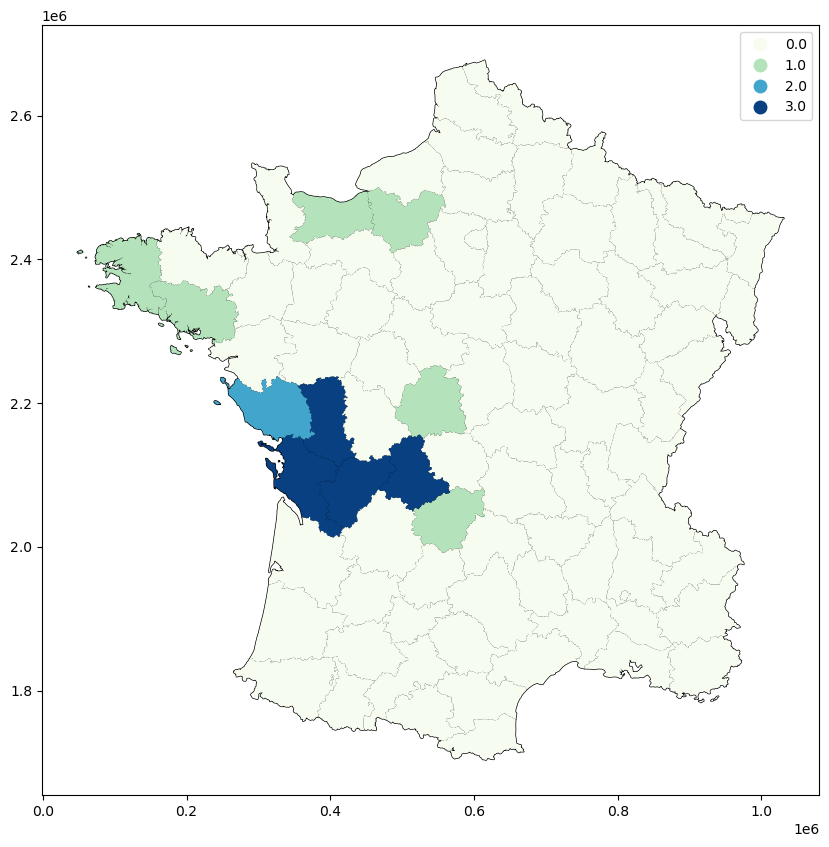

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_UNI',
               categorical=True,
               cmap='GnBu',
               legend=True, ax=ax)

或者将伴随的显着性值映射到低于某个阈值......

<Axes: >

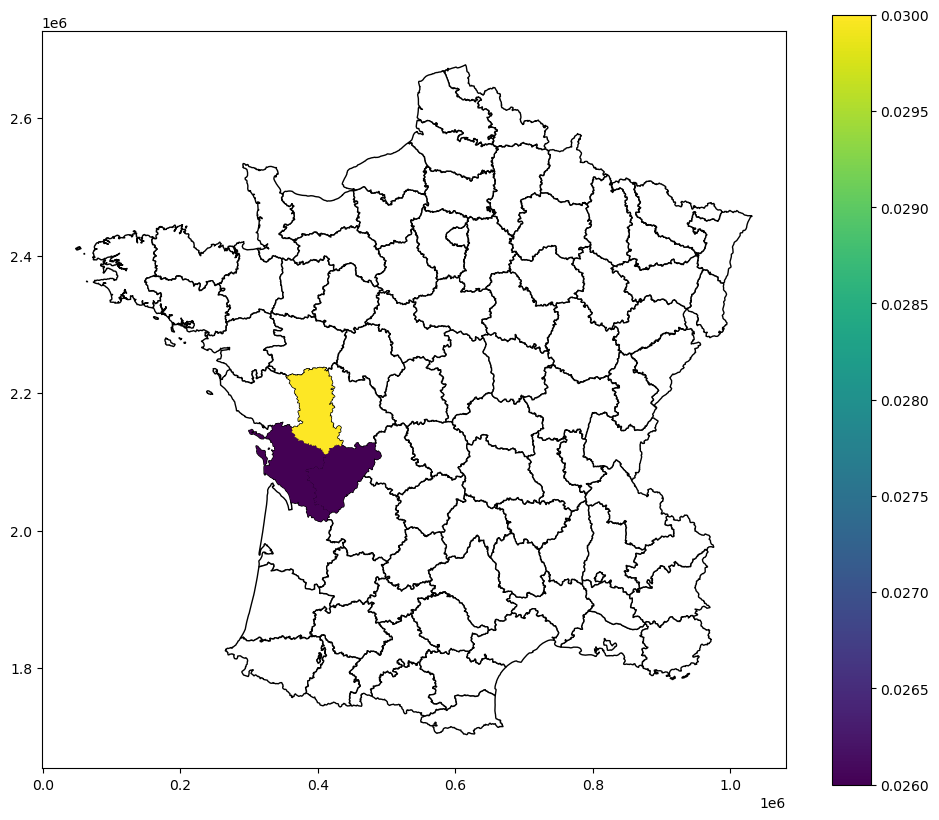

In [8]:
import numpy
guerry_ds['LJC_UNI_p_sim_sig'] = numpy.nan
guerry_ds.loc[(guerry_ds['LJC_UNI_p_sim'] <= 0.05), 'LJC_UNI_p_sim_sig'] = guerry_ds['LJC_UNI_p_sim'] 

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_UNI_p_sim_sig',
               legend=True, ax=ax)

## Bivariate LJC (case 1)

在双变量 LJC 中考虑两个变量（例如 $x$ 和 $z$）时，需要区分感兴趣的空间模式。 Anselin 和 Li 定义了该统计数据的两个用例。 第一个用例是**没有原位共置**，或者 $x_i$ 和 $z_i$ **不**在 $i$ 或 $j$ 处采用相同的值。 更具体地说，双变量 LJC 情况 1 感兴趣的是当 $x_i$ 和 $x_j$ 都等于 1（即 $x_i=x_j=1$）以及 $x_j=0$ 时。 从本质上讲，Anselin 和 Li 解释说，当 $x$ 和 $z$ 所代表的现象“不能发生在同一位置”时，case 是有用的。

形式上，这种情况表示为：

等式 2. $$ BJC_i = x_i (1 - z_i) \sum_{j} w_{ij} z_j (1-x_j)$$

如上所述，我们将双变量 LJC 情况 1 统计量的 PySAL 实现应用到其在  [GeoDa](https://geodacenter.github.io/workbook/6b_local_adv/lab6b.html#bivariate---no-co-location)中的原始实现。 与上面不同的是，我们现在转到[芝加哥数据集中的社区区域 (`commpop`)](https://geodacenter.github.io/data-and-lab//)。 我们将检查负空间自相关的实例，这些实例由负人口变化（“popneg=1”）的位置被更多具有正人口变化的位置（“popplus=1”）包围的位置来识别。

In [9]:
import libpysal
import geopandas as gpd
commpop = gpd.read_file("https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/commpop.gpkg")

我们再次创建一个 Queen-contiguity 权重对象来描述单位之间的关系。

In [10]:
w = libpysal.weights.Queen.from_dataframe(commpop)

现在我们运行“Local_Join_Count_BV”函数。 **注意变量的顺序是有意义的！**改变变量的顺序将会改变隐含的研究问题。

In [11]:
from esda.join_counts_local_bv import Join_Counts_Local_BV
LJC_BV_Case1 = Join_Counts_Local_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')

和以前一样，我们可以将结果放回“commpop”数据集后映射“LJC”和“p_sim”值。

In [12]:
commpop['LJC_BV_Case1'] = LJC_BV_Case1.LJC
commpop['LJC_BV_Case1_p_sim'] = LJC_BV_Case1.p_sim

<Axes: >

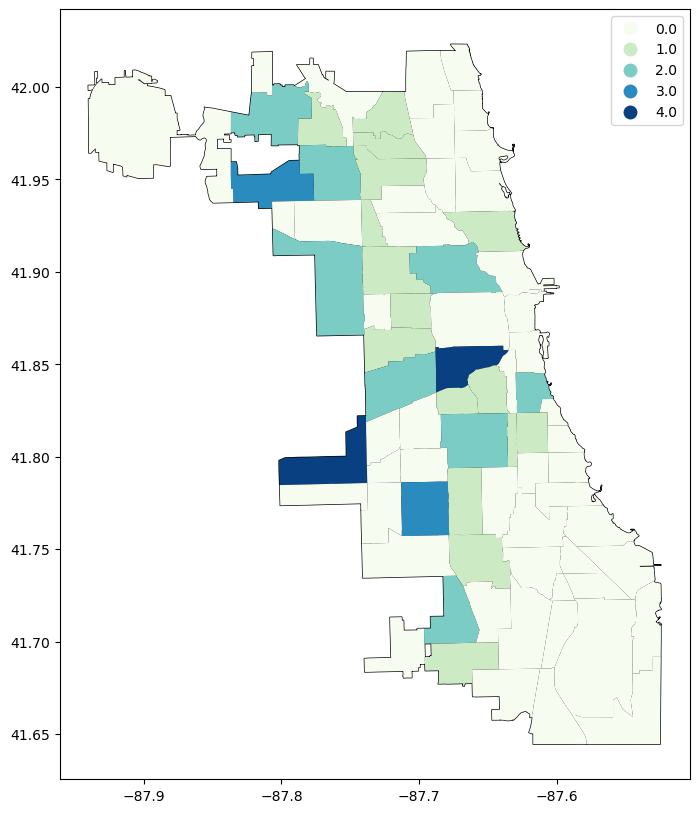

In [13]:
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
commpop.plot(color='white', edgecolor='black', ax=ax)
commpop.plot(column='LJC_BV_Case1',
             cmap='GnBu',
             categorical=True,
             legend=True, ax=ax)

<Axes: >

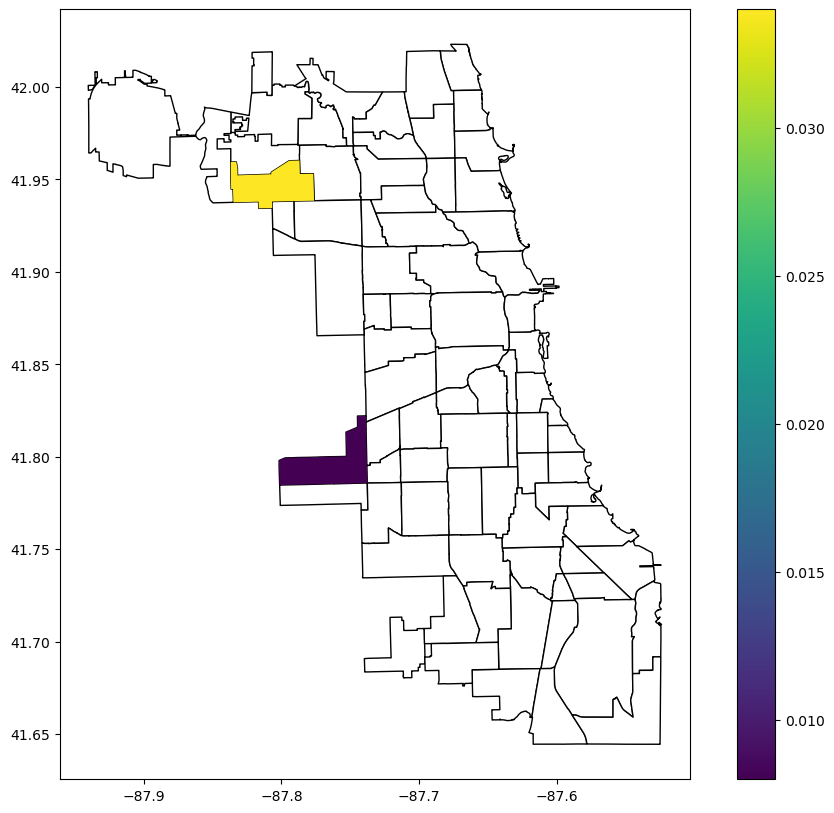

In [14]:
commpop['LJC_BV_Case1_p_sim_sig'] = numpy.nan
commpop.loc[(commpop['LJC_BV_Case1_p_sim'] <= 0.05), 'LJC_BV_Case1_p_sim_sig'] = commpop['LJC_BV_Case1_p_sim'] 

fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
commpop.plot(color='white', edgecolor='black', ax=ax)
commpop.plot(column='LJC_BV_Case1_p_sim_sig',
               legend=True, ax=ax)

## Bivariate LJC (case 2)

现在我们继续讨论双变量 LJC 的情况 2。 与案例 1 不同，案例 2 **标识具有共置位置的区域**。 情况 2 明确涉及 $x_i=z_i=1$ 以及 $x_j=z_j=1$ 的实例。 Anselin 和 Li 将这种情况称为**共置集群 (CLC)**。 我们正式将其写为：

$$ CLC_i = x_i * z_i \sum_j w_{ij} x_j z_j $$

我们返回 Guerry 数据集来演示其在 PySAL 中的实现。 我们感兴趣的是确定变量“Infants”（非婚生儿童）和“Donatns”（捐赠）位于顶部分位数的区域。 我们重新加载数据集并创建以下变量：

In [15]:
guerry = libpysal.examples.load_example('Guerry')
guerry_ds = gpd.read_file(guerry.get_path('guerry.shp'))
guerry_ds['infq5'] = 0
guerry_ds['donq5'] = 0
guerry_ds.loc[(guerry_ds['Infants'] > 23574), 'infq5'] = 1
guerry_ds.loc[(guerry_ds['Donatns'] > 10973), 'donq5'] = 1

我们再次创建一个 Queen-contiguity 权重对象来描述单位之间的关系。

In [16]:
w = libpysal.weights.Queen.from_dataframe(guerry_ds)

我们现在运行“Local_Join_Count_BV”命令，这次将“case”参数更改为“CLC”。

In [17]:
LJC_BV_Case2 = Join_Counts_Local_BV(connectivity=w).fit(guerry_ds['infq5'], guerry_ds['donq5'], case='CLC')

和以前一样，我们可以映射“LJC”和随附的“p_sim”值。

In [18]:
guerry_ds['LJC_BV_Case2'] = LJC_BV_Case2.LJC
guerry_ds['LJC_BV_Case2_p_sim'] = LJC_BV_Case2.p_sim

<Axes: >

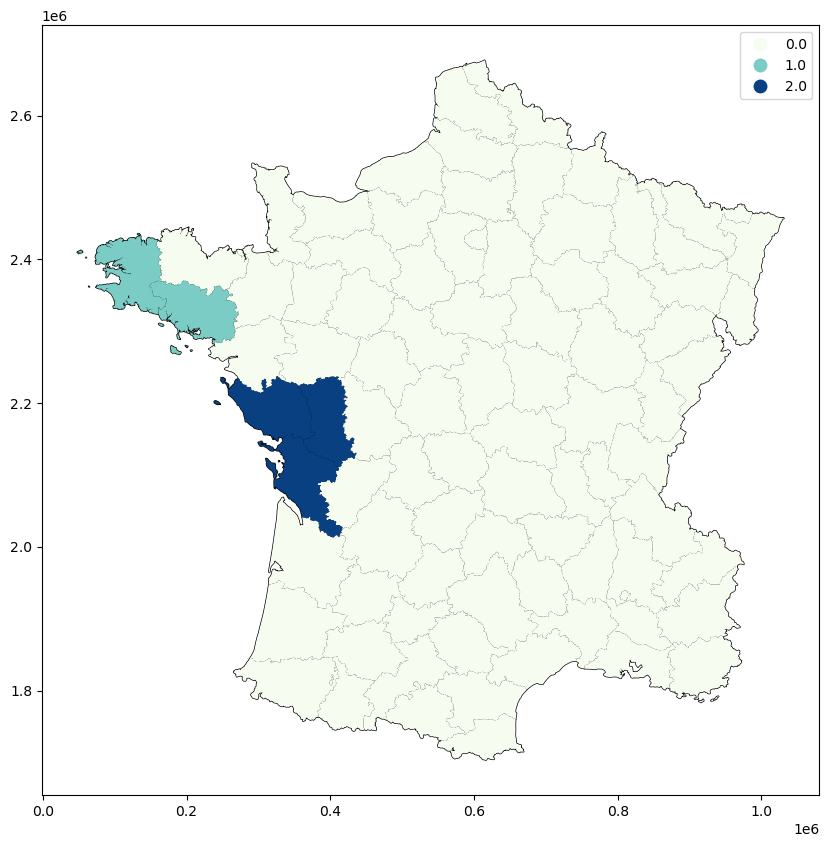

In [19]:
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_BV_Case2',
             cmap='GnBu',
             categorical=True,
             legend=True, ax=ax)

<Axes: >

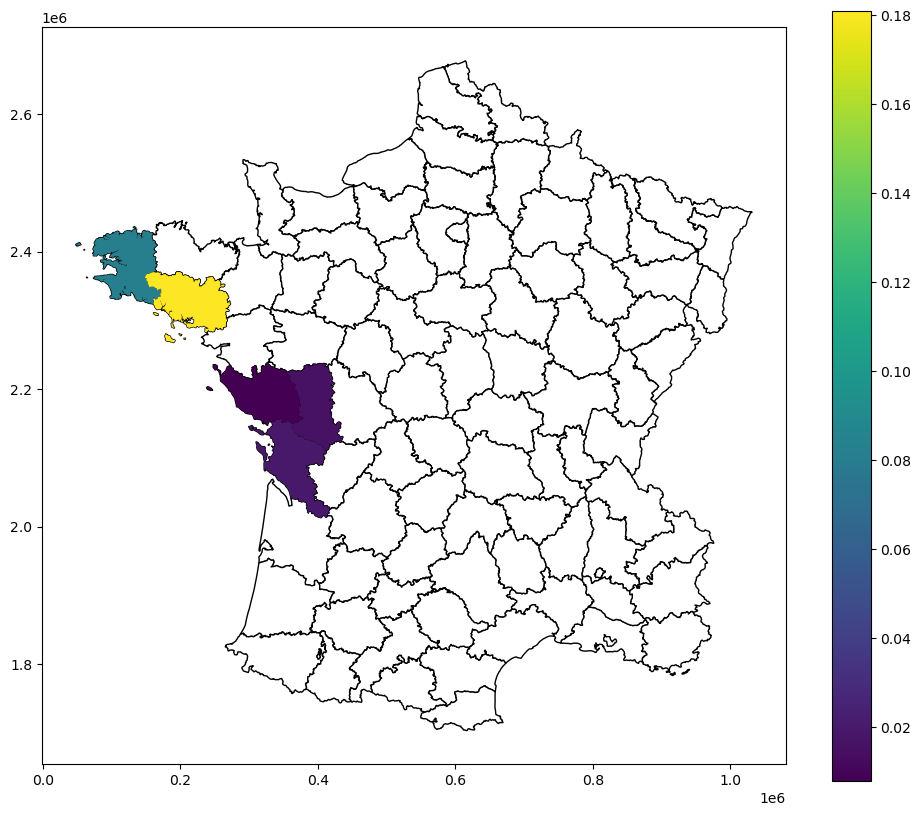

In [20]:
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_BV_Case2_p_sim',
               legend=True, ax=ax)

## Multivariate LJC

最后要回顾的 LJC 是多元 LJC 统计量。 这实际上是双变量 LJC 情况 2 的扩展。多元统计量不是考虑两个变量 $x$ 和 $z$，而是考虑每个位置 $i$ 处的 $m$ 个变量。 所有 $m$ 变量必须满足等于 1 的共置标准。形式上：

$$ CLC_i = \Pi^m_{h=1} x_{hi} \sum_j w_{ij} \Pi^m_{h=1} x_{hj} $$

Anselin 和 Li 在多个来源中明确指出，虽然多变量 LJC 统计量是双变量 LJC 案例 2 的直接扩展，但其实质含义并不那么简单。 用他们自己的话说：

> 多个二元变量的扩展在数学上是简单的，尽管在概念上可能不太简单。 虽然可能有不同的组合，但最实际的用例是关注点集中于与邻居的共置一致的多个变量的共置。 同样，我们可以将其称为共置集群。 一个例子是二进制变量
根据观测值落在预先指定范围（例如上十分位数）的位置的连续值度量构建。 共址簇将指示具有相似重合的邻居发生此类重合的位置。 然而，随着考虑的变量数量增加，我们会遇到“维数诅咒”，结果将不再那么有意义，因为这种巧合可能会越来越罕见，因此总是被标记为“显着”。 *Anselin 和 Li，2019 年，第 3.3 节，第 198 页*

我们通过扩展双变量 LJC 案例 2 的示例来演示这个问题。我们添加第三个变量来计算某个地区的自杀人数（“Suicids”）。 现在感兴趣的实质性问题正在寻找非婚生子女数量、向穷人捐款的数量以及自杀数量处于最高分位数的区域。 我们重新加载 Guerry 数据集并创建变量：

In [21]:
guerry = libpysal.examples.load_example('Guerry')
guerry_ds = gpd.read_file(guerry.get_path('guerry.shp'))
guerry_ds['infq5'] = 0
guerry_ds['donq5'] = 0
guerry_ds['suic5'] = 0
guerry_ds.loc[(guerry_ds['Infants'] > 23574), 'infq5'] = 1
guerry_ds.loc[(guerry_ds['Donatns'] > 10973), 'donq5'] = 1
guerry_ds.loc[(guerry_ds['Suicids'] > 55564), 'suic5'] = 1

并再次创建 Queen 邻接空间权重对象。

In [22]:
w = libpysal.weights.Queen.from_dataframe(guerry_ds)

我们现在加载“Local_Join_Count_MV”函数并将其应用于所有三个变量：

In [23]:
from esda.join_counts_local_mv import Join_Counts_Local_MV
LJC_MV = Join_Counts_Local_MV(connectivity=w).fit([guerry_ds['infq5'], guerry_ds['donq5'], guerry_ds['suic5']])

在进行绘图之前，值得检查是否有**任何**区域满足上述标准。

In [24]:
LJC_MV.LJC

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

由于没有符合标准的区域，因此没有区域具有显着性值。

In [25]:
LJC_MV.p_sim

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

尽管如此，重要的是要认识到这样的发现**作为“无效”结果可能仍然很重要！**